cs675 intro to datascience

priject 2

Rishiraj Rana


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly
import statsmodels
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
df = pd.read_csv('/content/telco-customer-churn.csv')

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
for col in df.columns:
  print(col,df[col].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

In [ ]:
#label encoding

for col in df.columns:
    # i have only used 0 and 1 for binary values
    df.loc[df[col] == "Yes", col] = 1
    df.loc[df[col] == "No", col] = 0
    df.loc[df[col] == "Female", col] = 0
    df.loc[df[col] == "Male", col] = 1
    # everything else is represented with a distinct integer
    df.loc[df[col] == "No phone service", col] = 2
    df.loc[df[col] == "No internet service", col] = 3
    df.loc[df[col] == "DSL", col] = 4
    df.loc[df[col] == "Fiber optic", col] = 5
    df.loc[df[col] == "Month-to-month", col] = 6
    df.loc[df[col] == "One year", col] = 7
    df.loc[df[col] == "Two year", col] = 8
    df.loc[df[col] == "Electronic check", col] = 9
    df.loc[df[col] == "Mailed check", col] = 10
    df.loc[df[col] == "Bank transfer (automatic)", col] = 11
    df.loc[df[col] == "Credit card (automatic)", col] = 12
    # setting missing values to -1, so that these values correspond to missing values
    df.loc[df[col] == " ", col] = -1

In [ ]:
# obtaining list of all columns which we need to convert
cols_to_convert_to_int = df.columns[np.where(df.dtypes=="object")]
cols_to_convert_to_int = cols_to_convert_to_int[1:] # we are excluding the customerID column

In [ ]:
# converting each of the targeted columns to integer type
for col in cols_to_convert_to_int:
    df[col] = pd.to_numeric(df[col])

In [ ]:
df.dtypes

,0
customerID,object
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
MultipleLines,int64
InternetService,int64
OnlineSecurity,int64


In [ ]:
df = df.drop([0])

In [ ]:
#splitting the dataset into 80-20 ratio (training-testing splits)

X = df.drop(['customerID','Churn'],axis=1)
Y = df['Churn']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

column_names = ["method","accuracy","precision","recall","f1"]
final_results_no_smote = pd.DataFrame(columns=column_names)
final_results_smote = pd.DataFrame(columns=column_names)
final_results_hyp = pd.DataFrame(columns=column_names)

normal predictions

In [ ]:
# 1. NAIVE BAYES

nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_predictions = nb.predict(X_test)

In [ ]:
nb_accuracy_score = accuracy_score(Y_test,nb_predictions)
nb_precision_score = precision_score(Y_test,nb_predictions)
nb_recall_score = recall_score(Y_test,nb_predictions)
nb_f1_score = f1_score(Y_test,nb_predictions)
nb_confusion = confusion_matrix(Y_test,nb_predictions)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Naive Bayes",nb_accuracy_score,nb_precision_score,nb_recall_score,nb_f1_score]

In [ ]:
model_dt = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8)
model_dt.fit(X_train, Y_train)
dt_predictions = model_dt.predict(X_test)

In [ ]:
dt_accuracy_score = accuracy_score(Y_test,dt_predictions)
dt_precision_score = precision_score(Y_test,dt_predictions)
dt_recall_score = recall_score(Y_test,dt_predictions)
dt_f1_score = f1_score(Y_test,dt_predictions)
dt_confusion = confusion_matrix(Y_test,dt_predictions)

In [ ]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Descion Trees",dt_accuracy_score,dt_precision_score,dt_recall_score,dt_f1_score]

In [ ]:
#2. LOGISTIC REGRESSION

lr = LogisticRegression(random_state=0)
lr.fit(X_train, Y_train)
lr_predictions = lr.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lr_accuracy_score = accuracy_score(Y_test,lr_predictions)
lr_precision_score = precision_score(Y_test,lr_predictions)
lr_recall_score = recall_score(Y_test,lr_predictions)
lr_f1_score = f1_score(Y_test,lr_predictions)
lr_confusion = confusion_matrix(Y_test,lr_predictions)

In [ ]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Logistic Regression",lr_accuracy_score,lr_precision_score,lr_recall_score,lr_f1_score]

In [ ]:
#3. RANDOM FOREST

rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, Y_train)
rf_predictions = rf.predict(X_test)
rf_predictions = [int(x) for x in np.round(rf_predictions,0)]

In [ ]:
rf_accuracy_score = accuracy_score(Y_test,rf_predictions)
rf_precision_score = precision_score(Y_test,rf_predictions)
rf_recall_score = recall_score(Y_test,rf_predictions)
rf_f1_score = f1_score(Y_test,rf_predictions)
rf_confusion = confusion_matrix(Y_test,rf_predictions)

In [ ]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["Random Forest",rf_accuracy_score,rf_precision_score,rf_recall_score,rf_f1_score]

In [ ]:
#4. XGBOOST

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,Y_train)
xgb_predictions = xgb_classifier.predict(X_test)

In [ ]:
xgb_accuracy_score = accuracy_score(Y_test,xgb_predictions)
xgb_precision_score = precision_score(Y_test,xgb_predictions)
xgb_recall_score = recall_score(Y_test,xgb_predictions)
xgb_f1_score = f1_score(Y_test,xgb_predictions)
xgb_confusion = confusion_matrix(Y_test,xgb_predictions)

In [ ]:
final_results_no_smote.loc[len(final_results_no_smote)] = ["XGBoost",xgb_accuracy_score,xgb_precision_score,xgb_recall_score,xgb_f1_score]

In [ ]:
#comparing results for no smote

final_results_no_smote

,method,accuracy,precision,recall,f1
0,Naive Bayes,0.652236,0.415323,0.848901,0.557762
1,Descion Trees,0.797019,0.630000,0.519231,0.569277
2,Logistic Regression,0.810504,0.652038,0.571429,0.609078
3,Random Forest,0.789922,0.604938,0.538462,0.569767
4,XGBoost,0.793471,0.608309,0.563187,0.584879


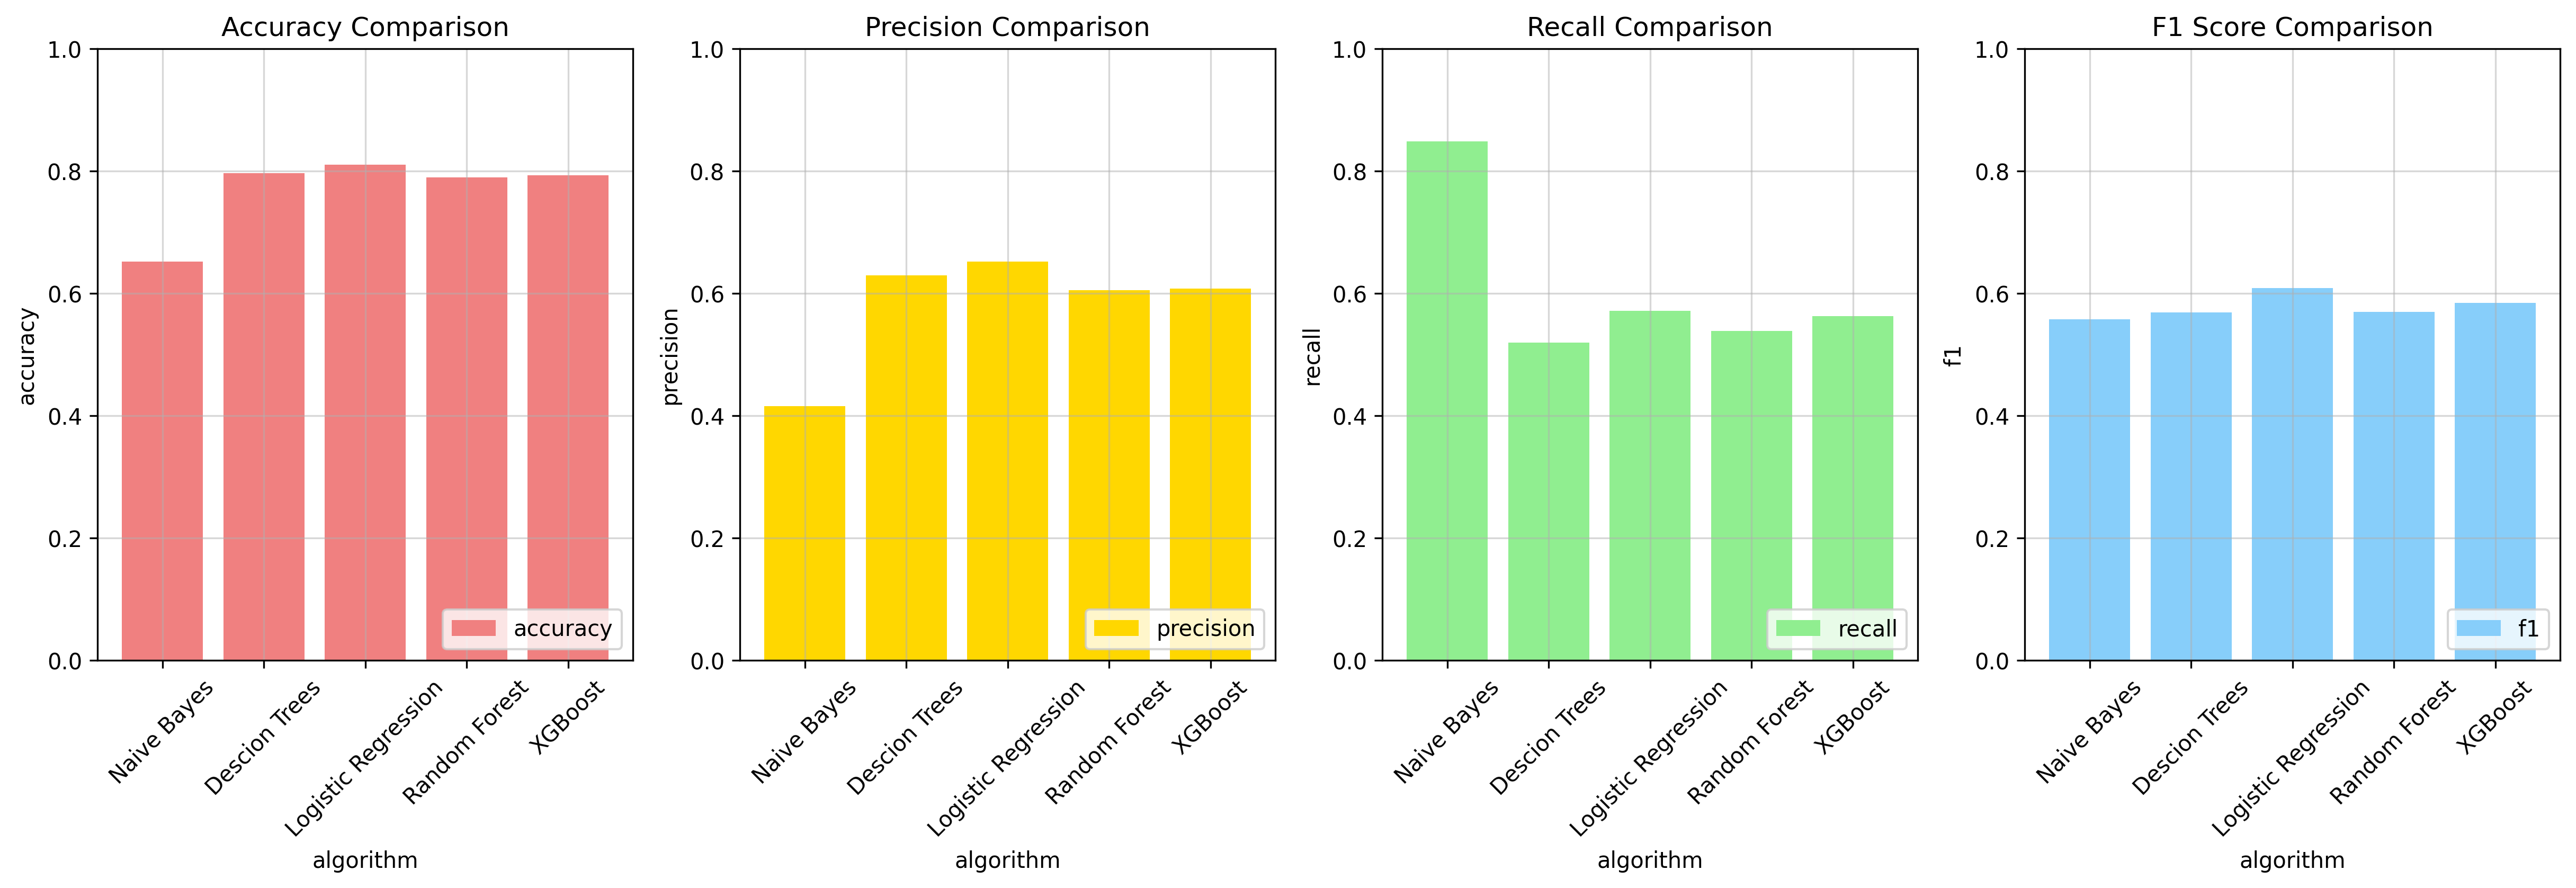

In [ ]:
#Comparing all thematrices for this analysis

fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_no_smote['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,final_results_no_smote['accuracy'],color="lightcoral",alpha=1,label="accuracy")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,final_results_no_smote['precision'],color="gold",alpha=1,label="precision")
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,final_results_no_smote['recall'],color="lightgreen",alpha=1,label="recall")
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,final_results_no_smote['f1'],color="lightskyblue",alpha=1,label="f1")
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

Predicting using SMOTE

this is the part where the previous part is repeated but with using SMOTE METHOD.This method deals with imbalances in the dataset in regards to classification labels. Normally, due to the class imbalance, the majority class will have better performance than the minority class. SMOTE deals with this by oversampling the minority class.

In [ ]:
X = df.drop(['customerID','Churn'],axis=1)
Y = df['Churn']
# splitting the data into an 80% training/20% testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.combine import SMOTEENN

sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X_train, Y_train)

In [ ]:
#Naive Bayes with SMOTE

nb_smote = GaussianNB()
nb_smote.fit(X_resampled, y_resampled)
nb_smote_predictions = nb_smote.predict(X_test)

In [ ]:
nb_smote_accuracy_score = accuracy_score(Y_test,nb_smote_predictions)
nb_smote_precision_score = precision_score(Y_test,nb_smote_predictions)
nb_smote_recall_score = recall_score(Y_test,nb_smote_predictions)
nb_smote_f1_score = f1_score(Y_test,nb_smote_predictions)
nb_smote_confusion = confusion_matrix(Y_test,nb_smote_predictions)

In [ ]:
final_results_smote.loc[len(final_results_smote)] = ["Naive Bayes",nb_smote_accuracy_score,nb_smote_precision_score,nb_smote_recall_score,nb_smote_f1_score]

In [ ]:
# Train-test split for resampled data
from sklearn.metrics import classification_report # Importing the classification_report function
xr_train, xr_test, yr_train, yr_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

# Decision Tree Classifier with SMOTEENN
model_dt_smote = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=6, min_samples_leaf=8)
model_dt_smote.fit(xr_train, yr_train)

# Predicting and evaluating Decision Tree model
yr_predict = model_dt_smote.predict(xr_test)
dt_accuracy_score = accuracy_score(yr_test, yr_predict)
model_score_r = model_dt_smote.score(xr_test, yr_test)

print("Decision Tree Accuracy Score:", dt_accuracy_score)
print("Model Score (Accuracy):", model_score_r)
print(classification_report(yr_test, yr_predict)) # Now classification_report is accessible

# Storing final results
final_results_smote.loc[len(final_results_smote)] = ["Decision Tree", dt_accuracy_score, model_score_r, nb_smote_recall_score, nb_smote_f1_score]

Decision Tree Accuracy Score: 0.9255663430420712
Model Score (Accuracy): 0.9255663430420712
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       431
           1       0.92      0.94      0.93       496

    accuracy                           0.93       927
   macro avg       0.93      0.92      0.93       927
weighted avg       0.93      0.93      0.93       927



In [ ]:
final_results_smote.loc[len(final_results_smote)] = ["Decison Tree",dt_accuracy_score,model_score_r,nb_smote_recall_score,nb_smote_f1_score]

In [ ]:
from sklearn import metrics

# Train the model
model_dt_smote.fit(xr_train, yr_train)

# Make predictions
yr_predict = model_dt_smote.predict(xr_test)

# Get the accuracy score
model_score_r = model_dt_smote.score(xr_test, yr_test)  # This returns the accuracy

# Print the accuracy
print("Accuracy:", model_score_r)

# Print the classification report
print(metrics.classification_report(yr_test, yr_predict))

Accuracy: 0.9255663430420712
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       431
           1       0.92      0.94      0.93       496

    accuracy                           0.93       927
   macro avg       0.93      0.92      0.93       927
weighted avg       0.93      0.93      0.93       927



In [ ]:
#Logistic Regression with SMOTE

lr_smote = LogisticRegression(random_state=0)
lr_smote.fit(X_resampled, y_resampled)
lr_smote_predictions = lr_smote.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lr_smote_accuracy_score = accuracy_score(Y_test,lr_smote_predictions)
lr_smote_precision_score = precision_score(Y_test,lr_smote_predictions)
lr_smote_recall_score = recall_score(Y_test,lr_smote_predictions)
lr_smote_f1_score = f1_score(Y_test,lr_smote_predictions)
lr_smote_confusion = confusion_matrix(Y_test,lr_smote_predictions)

In [ ]:
final_results_smote.loc[len(final_results_smote)] = ["Logistic Regression",lr_smote_accuracy_score,lr_smote_precision_score,lr_smote_recall_score,lr_smote_f1_score]

In [ ]:
#Ransdom Forest with SMOTE

rf_smote = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_smote.fit(X_resampled, y_resampled)
rf_smote_predictions = rf_smote.predict(X_test)
rf_smote_predictions = [int(x) for x in np.round(rf_smote_predictions,0)]

In [ ]:
rf_smote_accuracy_score = accuracy_score(Y_test,rf_smote_predictions)
rf_smote_precision_score = precision_score(Y_test,rf_smote_predictions)
rf_smote_recall_score = recall_score(Y_test,rf_smote_predictions)
rf_smote_f1_score = f1_score(Y_test,rf_smote_predictions)
rf_smote_confusion = confusion_matrix(Y_test,rf_smote_predictions)

In [ ]:
final_results_smote.loc[len(final_results_smote)] = ["Random Forest",rf_smote_accuracy_score,rf_smote_precision_score,rf_smote_recall_score,rf_smote_f1_score]

In [ ]:
#XBG Boost with SMOTE

xgb_smote = xgb.XGBClassifier()
xgb_smote.fit(X_resampled, y_resampled)
xgb_smote_predictions = xgb_smote.predict(X_test)

In [ ]:
xgb_smote_accuracy_score = accuracy_score(Y_test,xgb_smote_predictions)
xgb_smote_precision_score = precision_score(Y_test,xgb_smote_predictions)
xgb_smote_recall_score = recall_score(Y_test,xgb_smote_predictions)
xgb_smote_f1_score = f1_score(Y_test,xgb_smote_predictions)
xgb_smote_confusion = confusion_matrix(Y_test,xgb_smote_predictions)

In [ ]:
final_results_smote.loc[len(final_results_smote)] = ["XGBoost",xgb_smote_accuracy_score,xgb_smote_precision_score,xgb_smote_recall_score,xgb_smote_f1_score]

In [ ]:
#comparing result for this stage

final_results_smote

,method,accuracy,precision,recall,f1
0,Naive Bayes,0.716111,0.471787,0.826923,0.600798
1,Naive Bayes,0.716111,0.471787,0.826923,0.600798
2,Decision Tree,0.925566,0.925566,0.826923,0.600798
3,Decison Tree,0.925566,0.925566,0.826923,0.600798
4,Logistic Regression,0.723918,0.478559,0.766484,0.589229
5,Random Forest,0.766501,0.534381,0.747253,0.623139
6,XGBoost,0.766501,0.535497,0.725275,0.616103


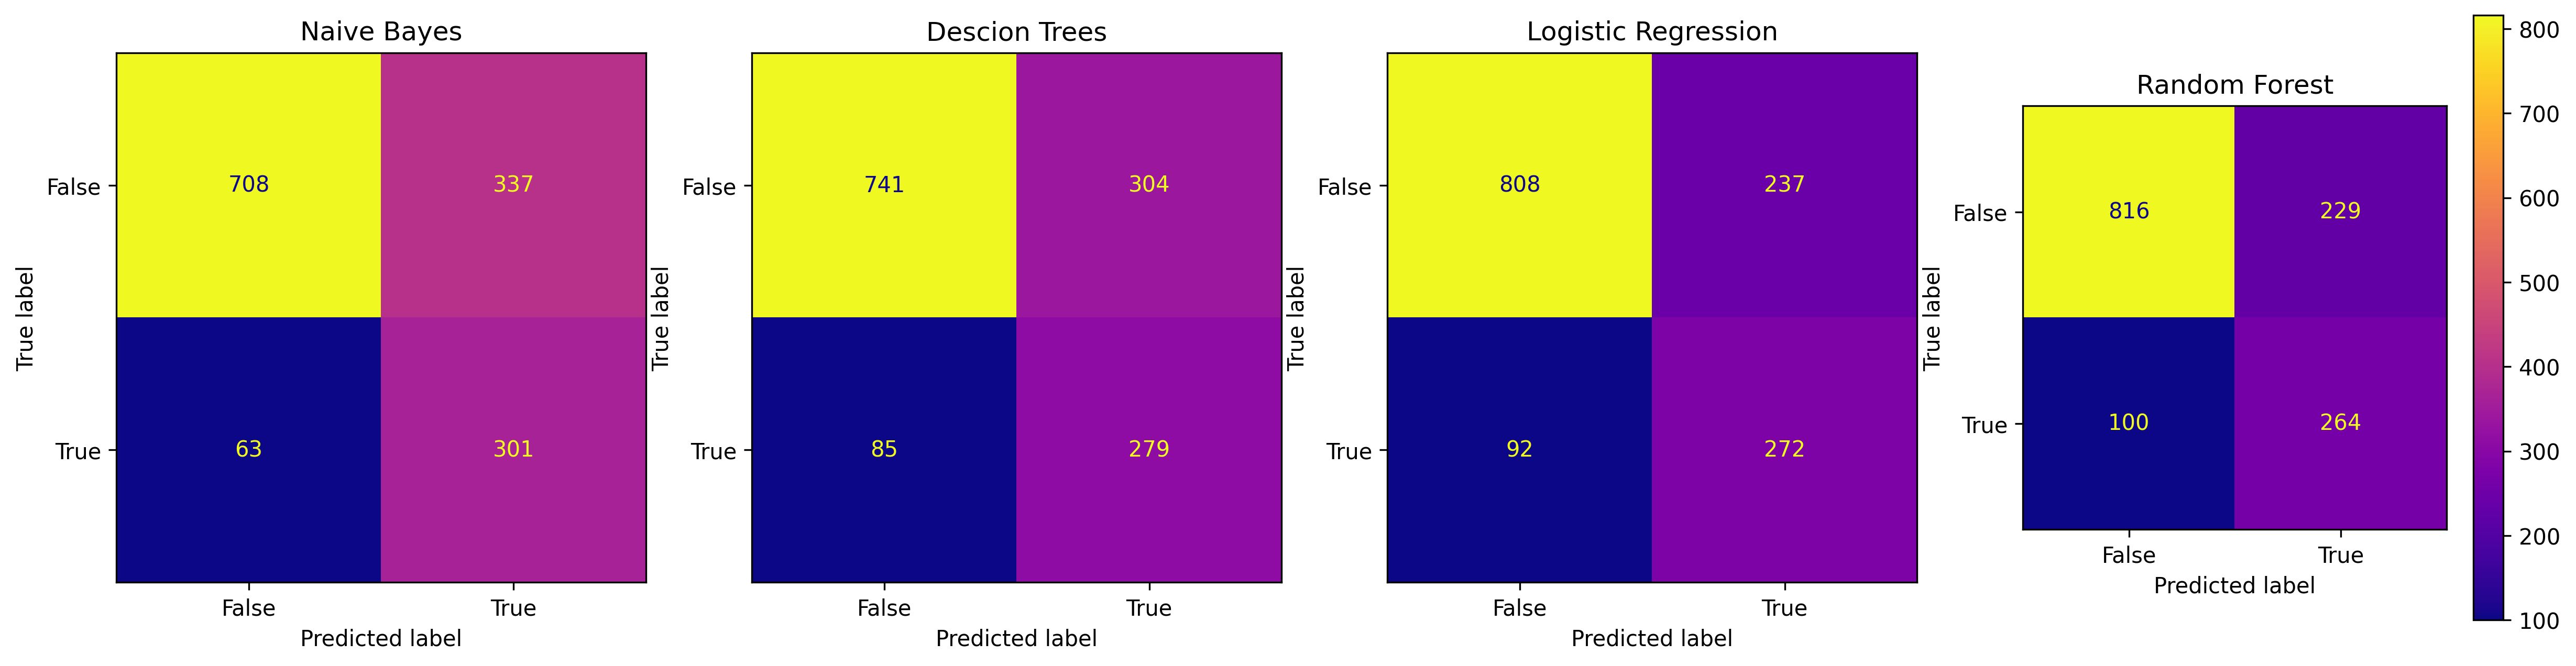

In [ ]:
#comparing confusion matrices
fig, ax = plt.subplots(1,4,sharex=False, sharey=False, figsize=(20, 5), dpi=300)
ax[0].set_title(x_labels[0])
ax[1].set_title(x_labels[1])
ax[2].set_title(x_labels[2])
ax[3].set_title(x_labels[3])

ConfusionMatrixDisplay(nb_smote_confusion,display_labels=[False,True]).plot(ax=ax[0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(lr_smote_confusion,display_labels=[False,True]).plot(ax=ax[1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(rf_smote_confusion,display_labels=[False,True]).plot(ax=ax[2],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(xgb_smote_confusion,display_labels=[False,True]).plot(ax=ax[3],cmap='plasma',colorbar=True)
fig.show()

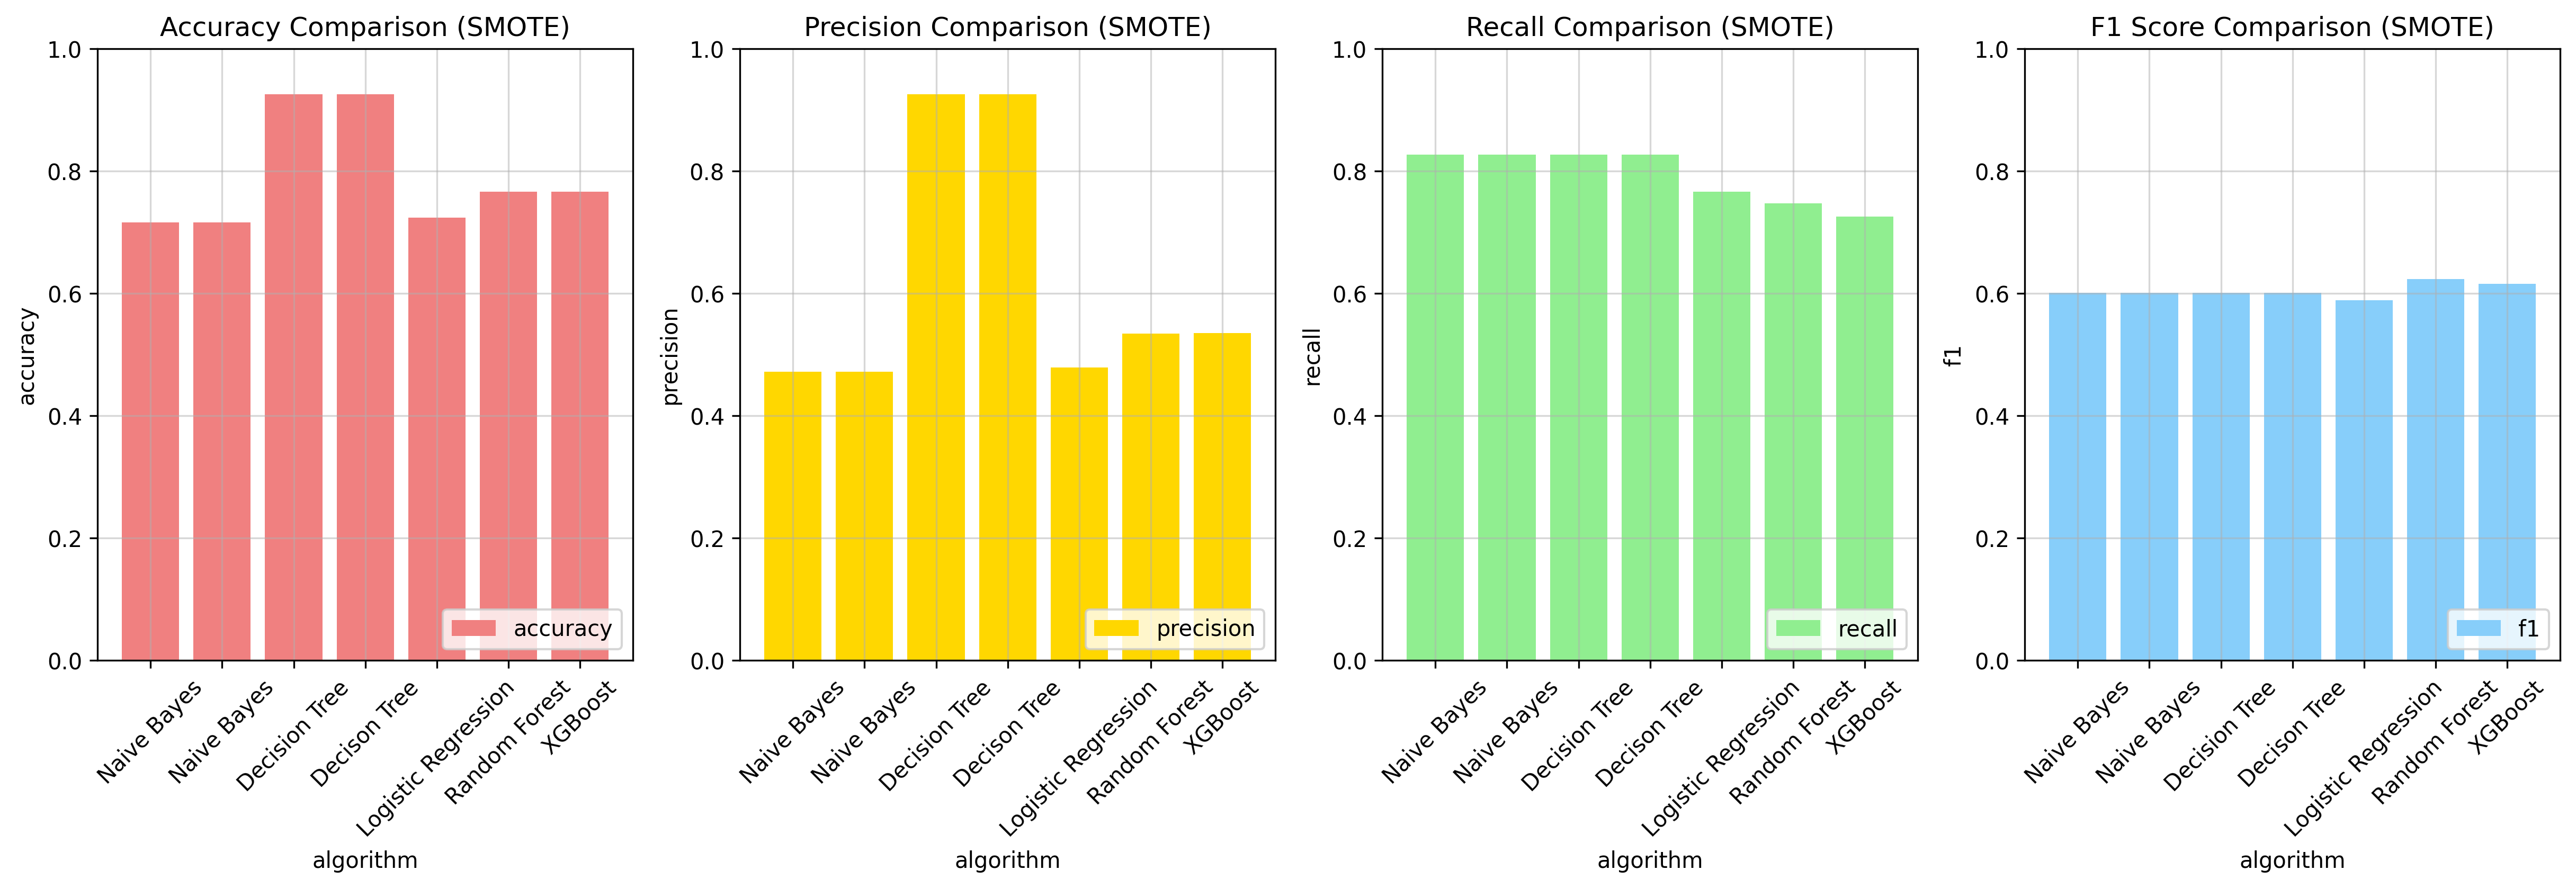

In [ ]:
# comparing all metrics for this stage of analysis
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = final_results_smote['method']
indices = np.arange(len(x_labels))
width = 0.3

# first row - NO Hyperparameters
#row=0, col=0
ax[0].bar(indices,final_results_smote['accuracy'],color="lightcoral",alpha=1,label="accuracy")
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison (SMOTE)")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,final_results_smote['precision'],color="gold",alpha=1,label="precision")
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison (SMOTE)")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,final_results_smote['recall'],color="lightgreen",alpha=1,label="recall")
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison (SMOTE)")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,final_results_smote['f1'],color="lightskyblue",alpha=1,label="f1")
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison (SMOTE)")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)